# 1. Pre processing

## 1-1 Read data

In [1]:
import pandas as pd
import numpy as np

columns_name = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak","slope","ca","thal","class"]

cleveland = pd.read_csv("/Users/hiroki/gitlab/CEML/Qiita/data/heart_row_data/processed.cleveland.data",header=None, names=columns_name)
hungarian = pd.read_csv("/Users/hiroki/gitlab/CEML/Qiita/data/heart_row_data/reprocessed.hungarian.data",sep=' ',header=None, names=columns_name)
va = pd.read_csv("/Users/hiroki/gitlab/CEML/Qiita/data/heart_row_data/processed.va.data",header=None, names=columns_name)
switzerland = pd.read_csv("/Users/hiroki/gitlab/CEML/Qiita/data/heart_row_data/processed.switzerland.data",sep=",",header=None, names=columns_name)

## 1-2 Merge data

In [2]:
merge_data = pd.concat([cleveland,hungarian,va,switzerland],axis=0)
print(merge_data.shape)

(921, 14)


## 1-3 Completion of missing value

In [3]:
merge_data.replace({"?":np.nan},inplace=True)
merge_data = merge_data.astype("float")

# クラスが欠損している行を削除
merge_data.dropna(subset=["class"], inplace=True)

merge_data.reset_index(inplace=True, drop=True)

# 欠損値確認
print(merge_data.isnull().sum())


age           0
sex           0
cp            0
trestbps     58
chol          7
fbs          82
restecg       1
thalach      54
exang        54
oldpeak      62
slope       119
ca          320
thal        220
class         0
dtype: int64


## 1-4 Feature engineering

In [4]:
merge_data['diff_age'] = merge_data['age'] - merge_data['age'].mean()

## 1-5 Split data 

Text(0, 0.5, 'number of sample')

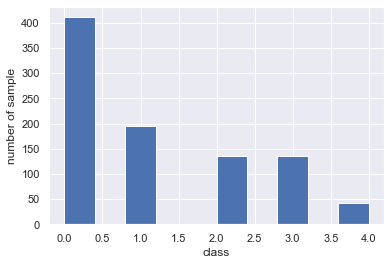

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

merge_data["class"].hist()
plt.xlabel("class")
plt.ylabel("number of sample")

train shape (588, 14)
test shape (184, 14)
validation shape (148, 14)


Text(0, 0.5, 'number of sample')

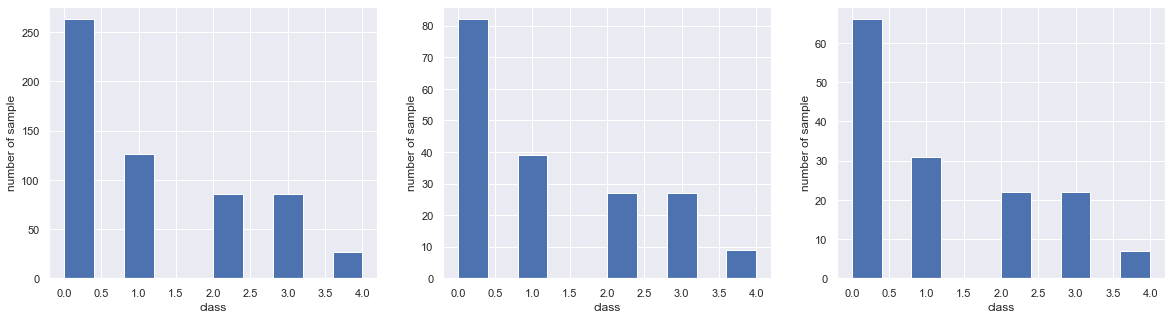

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

# 目的変数を分離
X = merge_data.drop("class",axis=1).values
y = merge_data["class"].values
columns_name = merge_data.drop("class",axis=1).columns

# 分類するための関数を定義
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0) 
def data_split(X,y):
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
    X_train = pd.DataFrame(X_train, columns=columns_name)
    X_test = pd.DataFrame(X_test, columns=columns_name)
    
    return X_train, y_train, X_test, y_test

# train, test, valに分離
X_train, y_train, X_test, y_test = data_split(X, y)
X_train, y_train, X_val, y_val = data_split(X_train.values, y_train)

# shape 確認
print("train shape", X_train.shape)
print("test shape", X_test.shape)
print("validation shape", X_val.shape)

# クラスの割合を確認
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.hist(y_train)
plt.xlabel("class")
plt.ylabel("number of sample")

plt.subplot(1,3,2)
plt.hist(y_test)
plt.xlabel("class")
plt.ylabel("number of sample")

plt.subplot(1,3,3)
plt.hist(y_val)
plt.xlabel("class")
plt.ylabel("number of sample")

# Model 

## 2-1. Define model and make dataset

In [7]:
import lightgbm as lgb

# categorical_feature = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# データセットを作成
train = lgb.Dataset(X_train, label=y_train)
valid = lgb.Dataset(X_val, label=y_val)

# モデルのパラメータを設定
params = {
    'reg_lambda' : 0.2,
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 5,
    'reg_alpha': 0.1,
    'min_data_leaf': 100,
    'learning_rate': 0.025,
}

## 2-2. Train model

In [8]:
model = lgb.train(params,
                  train,
                  valid_sets=valid,
                  num_boost_round=5000,
                  early_stopping_rounds=500)

[1]	valid_0's multi_logloss: 1.39098
Training until validation scores don't improve for 500 rounds
[2]	valid_0's multi_logloss: 1.38334
[3]	valid_0's multi_logloss: 1.37627
[4]	valid_0's multi_logloss: 1.36961
[5]	valid_0's multi_logloss: 1.36339
[6]	valid_0's multi_logloss: 1.35722
[7]	valid_0's multi_logloss: 1.35124
[8]	valid_0's multi_logloss: 1.34566
[9]	valid_0's multi_logloss: 1.34024
[10]	valid_0's multi_logloss: 1.33472
[11]	valid_0's multi_logloss: 1.32998
[12]	valid_0's multi_logloss: 1.32512
[13]	valid_0's multi_logloss: 1.32038
[14]	valid_0's multi_logloss: 1.31613
[15]	valid_0's multi_logloss: 1.31186
[16]	valid_0's multi_logloss: 1.30743
[17]	valid_0's multi_logloss: 1.30268
[18]	valid_0's multi_logloss: 1.29804
[19]	valid_0's multi_logloss: 1.29334
[20]	valid_0's multi_logloss: 1.28979
[21]	valid_0's multi_logloss: 1.28699
[22]	valid_0's multi_logloss: 1.28347
[23]	valid_0's multi_logloss: 1.28035
[24]	valid_0's multi_logloss: 1.27734
[25]	valid_0's multi_logloss: 1.274

In [9]:
# predict test
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = np.argmax(y_pred, axis=1)

kappa score: 0.3368649587494572


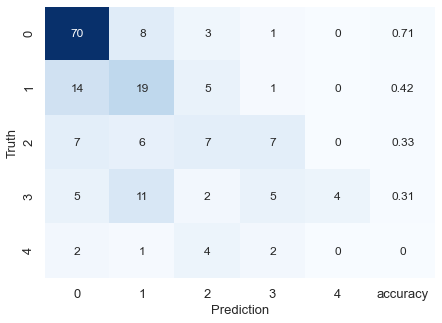

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score

# 混合行列を作成
result_matrix = pd.DataFrame(confusion_matrix(y_test,y_pred))
# クラス毎の正解率を計算
class_accuracy = [(result_matrix[i][i]/result_matrix[i].sum())*1 for i in range(len(result_matrix))]
result_matrix[5] = class_accuracy
#kappa係数を計算
kappa = cohen_kappa_score(y_test,y_pred)
print("kappa score:",kappa)

# plot
plt.figure(figsize=(7,5))
sns.heatmap(result_matrix,annot=True,cmap="Blues",cbar=False)
plt.xticks([5.5,4.5,3.5,2.5,1.5,0.5], ["accuracy",4, 3, 2, 1,0])
plt.ylabel('Truth',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.tick_params(labelsize = 13)

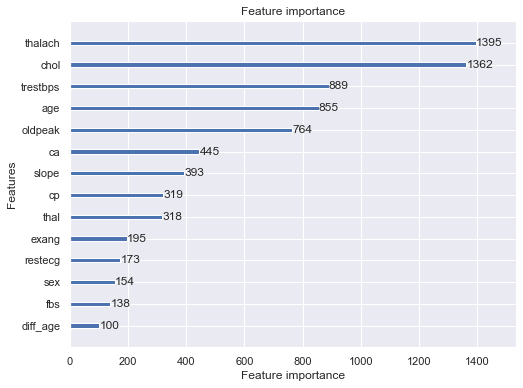

In [23]:
lgb.plot_importance(model, figsize=(8, 6))
plt.show()